In [2]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas
from pyspark.sql.functions import *
import seaborn as sns

In [3]:
spark = SparkSession.builder.appName("UsedCarPricePrediction").getOrCreate()
sc = spark.sparkContext

In [4]:
spark

#### Reading csv file in pyspark dataframe:

In [5]:
df = spark.read.csv(r"D:\DBDA\FINAL_PROJECT\v1\vehicles.csv",header=True, inferSchema=True)

In [6]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_url: string (nullable = true)
 |-- price: string (nullable = true)
 |-- year: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- cylinders: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: string (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- VIN: string (nullable = true)
 |-- drive: string (nullable = true)
 |-- size: string (nullable = true)
 |-- type: string (nullable = true)
 |-- paint_color: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- description: string (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- posting_date: string (nu

In [7]:
df.show(5)

+----------+--------------------+--------------------+--------------------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+----+-----+----+----+-----------+---------+-----------+------+-----+----+----+------------+
|        id|                 url|              region|          region_url|price|year|manufacturer|model|condition|cylinders|fuel|odometer|title_status|transmission| VIN|drive|size|type|paint_color|image_url|description|county|state| lat|long|posting_date|
+----------+--------------------+--------------------+--------------------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+----+-----+----+----+-----------+---------+-----------+------+-----+----+----+------------+
|7222695916|https://prescott....|            prescott|https://prescott....| 6000|null|        null| null|     null|     null|null|    null|        null|        null|null| null|null|null|       null|     null|       null|  null|  

In [8]:
df.columns

['id',
 'url',
 'region',
 'region_url',
 'price',
 'year',
 'manufacturer',
 'model',
 'condition',
 'cylinders',
 'fuel',
 'odometer',
 'title_status',
 'transmission',
 'VIN',
 'drive',
 'size',
 'type',
 'paint_color',
 'image_url',
 'description',
 'county',
 'state',
 'lat',
 'long',
 'posting_date']

#### Calculate the sum of null values for each column

In [9]:
from pyspark.sql.functions import sum as spark_sum

null_counts = df.select([spark_sum(col(column).isNull().cast('int')).alias(column) for column in df.columns])

# Show the counts
null_counts.show()


+---+----+------+----------+-----+----+------------+-----+---------+---------+-----+--------+------------+------------+------+------+------+------+-----------+---------+-----------+------+-----+-----+-----+------------+
| id| url|region|region_url|price|year|manufacturer|model|condition|cylinders| fuel|odometer|title_status|transmission|   VIN| drive|  size|  type|paint_color|image_url|description|county|state|  lat| long|posting_date|
+---+----+------+----------+-----+----+------------+-----+---------+---------+-----+--------+------------+------------+------+------+------+------+-----------+---------+-----------+------+-----+-----+-----+------------+
|  0|9884|  6901|      6533| 6446|7890|       28937|17506|   187143|   190798|16344|   17801|       21618|       15932|174486|144178|319997|106892|     143839|    13732|      13733|382283|23077|25397|24715|       22477|
+---+----+------+----------+-----+----+------------+-----+---------+---------+-----+--------+------------+------------+-

In [10]:
df.count()

441802

#### Drop the independent columns :

In [11]:
columns_to_delete = ['id', 'url', 'region_url','VIN','image_url','description','county','lat','long','posting_date','size','state']

df1 = df.drop(*columns_to_delete)

In [12]:
df1.columns

['region',
 'price',
 'year',
 'manufacturer',
 'model',
 'condition',
 'cylinders',
 'fuel',
 'odometer',
 'title_status',
 'transmission',
 'drive',
 'type',
 'paint_color']

In [13]:
df1.count()

441802

#### drop duplicated records :

In [14]:
df2 = df1.distinct()
df2.count()

376299

#### Calculate the percentage of null values for each column

In [15]:
null_counts = df2.select([spark_sum(col(column).isNull().cast('int')).alias(column) for column in df2.columns])

total_rows = df2.count()

null_percentages = null_counts.select([((col(column) / total_rows) * 100).alias(column + "_null_percentage") for column in df2.columns])

null_percentages.show()


+----------------------+---------------------+--------------------+----------------------------+---------------------+-------------------------+-------------------------+--------------------+------------------------+----------------------------+----------------------------+---------------------+--------------------+---------------------------+
|region_null_percentage|price_null_percentage|year_null_percentage|manufacturer_null_percentage|model_null_percentage|condition_null_percentage|cylinders_null_percentage|fuel_null_percentage|odometer_null_percentage|title_status_null_percentage|transmission_null_percentage|drive_null_percentage|type_null_percentage|paint_color_null_percentage|
+----------------------+---------------------+--------------------+----------------------------+---------------------+-------------------------+-------------------------+--------------------+------------------------+----------------------------+----------------------------+---------------------+------------

#### Drop rows with null values in specified columns

We can see that "year", "manufacturer", "model", and "odometer" column has less than 6% of null values. So we can simply drop those rows which have null values in these two columns.

In [16]:
df3 = df2.na.drop(subset=['region','price','year','model','odometer','manufacturer','transmission','title_status','fuel'])

In [17]:
df3.count()

338666

In [18]:
df3.printSchema()

root
 |-- region: string (nullable = true)
 |-- price: string (nullable = true)
 |-- year: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- cylinders: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: string (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- drive: string (nullable = true)
 |-- type: string (nullable = true)
 |-- paint_color: string (nullable = true)



#### Calculate the sum of null values for each column

In [39]:
null_counts = df3.select([spark_sum(col(column).isNull().cast('int')).alias(column) for column in df3.columns])

null_counts.show()

+------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+-----+-----+-----------+
|region|price|year|manufacturer|model|condition|cylinders|fuel|odometer|title_status|transmission|drive| type|paint_color|
+------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+-----+-----+-----------+
|     0|    0|   0|           0|    0|   127475|   136976|   0|       0|           0|           0|99666|70209|      94125|
+------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+-----+-----+-----------+



#### Handling Missing Values with Categorical Encoding

For all the missing values in other columns, we have just converted them in to a new category, "unknown"
In our data preprocessing pipeline, we've adopted a strategy to address missing values across various columns. When encountering missing data points in any column, we've uniformly encoded them as a new category labeled "unknown". This approach ensures that all missing values are consistently represented, enabling smoother data processing and analysis downstream.

#### Replace null values in all columns with 'unknown'

In [21]:
df4 = df3.fillna('unknown')

#### Again Calculate the sum of null values for each column

In [41]:
null_counts = df4.select([spark_sum(col(column).isNull().cast('int')).alias(column) for column in df4.columns])

null_counts.show()

+------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+-----+----+-----------+
|region|price|year|manufacturer|model|condition|cylinders|fuel|odometer|title_status|transmission|drive|type|paint_color|
+------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+-----+----+-----------+
|     0|    0|   0|           0|    0|        0|        0|   0|       0|           0|           0|    0|   0|          0|
+------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+-----+----+-----------+



#### Calculating each column unique values:

In [23]:
# Iterate over each column in the DataFrame
for col_name in df4.columns:
    # Count the distinct values in the column
    distinct_count = df4.select(countDistinct(col_name)).collect()[0][0]
    print(col_name, distinct_count)

region 414
price 14689
year 117
manufacturer 51
model 21876
condition 56
cylinders 18
fuel 16
odometer 99837
title_status 16
transmission 79
drive 12
type 22
paint_color 49


###  handling cloumns :
#### manufacturer 

In [42]:
null_count = df4.filter(col("manufacturer").isNull()).count()
print("null records" ,null_count)

null_count = df4.filter(col("manufacturer").isNotNull()).count()
print("not null records" ,null_count)

total_count = df4.select('manufacturer').count()
print("total count ",total_count)

value_counts = df4.groupBy('manufacturer').count()
value_counts.show(60)

# Get unique records of a specific column
unique_records = df4.select("manufacturer").distinct().count()
print("unique_records =",unique_records)

null records 0
not null records 338666
total count  338666
+--------------------+-----+
|        manufacturer|count|
+--------------------+-----+
|              jaguar| 1791|
|               buick| 4667|
|          mitsubishi| 2746|
|             pontiac| 1988|
| pricing and othe...|   40|
|               lexus| 7005|
|              toyota|28244|
|            chrysler| 4939|
|               tesla|  781|
|             lincoln| 3670|
|                audi| 6683|
|              datsun|   61|
|                 bmw|12577|
|                jeep|15478|
|               dodge|10805|
|               rover| 1543|
|             hyundai| 8229|
|                ford|58558|
|          alfa-romeo|  854|
|            cadillac| 5748|
|                 ram|14240|
|               mazda| 4585|
|             ferrari|   67|
|                 kia| 6812|
|       mercedes-benz| 9864|
|             porsche| 1136|
|        aston-martin|   22|
|              saturn|  918|
|           chevrolet|45189|
|            

#### categorical variable grouping

This step can be called "categorical variable grouping". It involves grouping less frequent categories of a categorical variable into a single category to simplify the data and potentially improve model performance.

In [43]:
from pyspark.sql.functions import when

# Define the list of top 20 manufacturers
manufacturer_values = ['nissan','honda','chevrolet','mercedes-benz','ram','dodge','ford','jeep','toyota','bmw','subaru','volkswagen','kia','cadillac','hyundai','lexus','audi','chrysler','acura','buick']

# Use when function to update the 'manufacturer' column
df5 = df4.withColumn('manufacturer', 
                   when(df4['manufacturer'].isin(manufacturer_values), df4['manufacturer'])
                   .otherwise('others'))

In [44]:
null_count = df5.filter(col("manufacturer").isNull()).count()
print("null records" ,null_count)

null_count = df5.filter(col("manufacturer").isNotNull()).count()
print("not null records" ,null_count)

total_count = df5.select('manufacturer').count()
print("total count ",total_count)

value_counts = df5.groupBy('manufacturer').count()
value_counts.show(60)

# Get unique records of a specific column
unique_records = df5.select("manufacturer").distinct().count()
print("unique_records =",unique_records)

null records 0
not null records 338666
total count  338666
+-------------+-----+
| manufacturer|count|
+-------------+-----+
|        buick| 4667|
|        lexus| 7005|
|       toyota|28244|
|     chrysler| 4939|
|         audi| 6683|
|       others|45121|
|          bmw|12577|
|         jeep|15478|
|        dodge|10805|
|      hyundai| 8229|
|         ford|58558|
|     cadillac| 5748|
|          ram|14240|
|          kia| 6812|
|mercedes-benz| 9864|
|    chevrolet|45189|
|        honda|17657|
|   volkswagen| 8164|
|        acura| 5403|
|       nissan|15273|
|       subaru| 8010|
+-------------+-----+

unique_records =  21


#### region :

In [45]:
null_count = df5.filter(col("region").isNull()).count()
print("null records" ,null_count)

null_count = df5.filter(col("region").isNotNull()).count()
print("not null records" ,null_count)

total_count = df5.select('region').count()
print("total count ",total_count)

value_counts = df5.groupBy('region').count()
value_counts.show(60)

# Get unique records of a specific column
unique_records = df5.select("region").distinct().count()
print("unique_records =",unique_records)

null records 0
not null records 338666
total count  338666
+--------------------+-----+
|              region|count|
+--------------------+-----+
|   central louisiana|  116|
|          western KY|  205|
|           texarkana|  189|
|       daytona beach| 1212|
|   heartland florida|  153|
|  southeast missouri|  176|
|            sandusky|  230|
|        gold country|  648|
|           pensacola|  557|
|        south jersey| 2407|
|       new hampshire| 2202|
|          san marcos|  169|
|           fairbanks|  286|
|     kansas city, MO| 2383|
|          harrisburg|  768|
|       state college|  191|
|              yakima| 1266|
|          moses lake|  649|
|huntsville / decatur| 1051|
|   northern michigan|  556|
|       south florida| 2238|
|saginaw-midland-b...|  821|
|potsdam-canton-ma...|   86|
|        northwest OK|  136|
|             jackson|  954|
| dallas / fort worth| 2436|
|  mcallen / edinburg|  790|
|         long island| 2544|
|        northeast SD|   32|
|          bi

In [46]:
# Count the occurrences of each region value
manufacturer_counts = df5.groupBy('region').count()

# Sort the counts in descending order and select the top 50 region
top_manufacturers = manufacturer_counts.orderBy('count', ascending=False).limit(50)

# Extract the top 50 region values
manufacturer_values = [row['region'] for row in top_manufacturers.collect()]

# Use when function to update the 'region' column
df6 = df5.withColumn('region', 
                     when(df5['region'].isin(manufacturer_values), df5['region'])
                     .otherwise('others'))


In [47]:
null_count = df6.filter(col("region").isNull()).count()
print("null records" ,null_count)

null_count = df6.filter(col("region").isNotNull()).count()
print("not null records" ,null_count)

total_count = df6.select('region').count()
print("total count ",total_count)

value_counts = df6.groupBy('region').count()
value_counts.show(60)

# Get unique records of a specific column
unique_records = df6.select("region").distinct().count()
print("unique_records =",unique_records)

null records 0
not null records 338666
total count  338666
+--------------------+------+
|              region| count|
+--------------------+------+
|        south jersey|  2407|
|     kansas city, MO|  2383|
| dallas / fort worth|  2436|
|         long island|  2544|
|             atlanta|  2444|
|        jacksonville|  2511|
|             chicago|  2532|
|      seattle-tacoma|  2659|
|              denver|  2637|
|      tampa bay area|  2445|
|            stockton|  2468|
|           charlotte|  2367|
|          cincinnati|  2301|
|       orange county|  2465|
|        st louis, MO|  2359|
|    colorado springs|  2386|
|               boise|  2303|
|              boston|  2598|
|          pittsburgh|  2458|
|             orlando|  2426|
|           cleveland|  2284|
|           milwaukee|  2400|
|        grand rapids|  2519|
|              others|215680|
|               tulsa|  2272|
|      washington, DC|  2480|
|       oklahoma city|  2330|
|           las vegas|  2376|
|          

#### model :

In [38]:
null_count = df6.filter(col("model").isNull()).count()
print("null records" ,null_count)

null_count = df6.filter(col("model").isNotNull()).count()
print("not null records" ,null_count)

total_count = df6.select('model').count()
print("total count ",total_count)

value_counts = df6.groupBy('model').count()
value_counts.show(60)

# Get unique records of a specific column
unique_records = df6.select("model").distinct().count()
print("unique_records = ",unique_records)

null records 0
not null records 338666
total count  338666
+--------------------+-----+
|               model|count|
+--------------------+-----+
|             4runner|  899|
|       sonata hybrid|   73|
|                hr-v|  141|
|                 dts|  238|
|            lacrosse|  349|
|          crv lx awd|   22|
|         verano base|    8|
|transit connect c...|   26|
|           sentra sv|  132|
|  cherokee trailhawk|   25|
|journey r/t flexible|    2|
|           pruis two|    2|
|                 hse|   54|
|silverado 2500hd ...|    5|
|                 xk8|   25|
|          charger se|   50|
|journey se sport ...|   34|
|            aerostar|    5|
|      avalon limited|   58|
|           cts sedan|   42|
|                 q40|    8|
|      f-150 long bed|    1|
|               azera|   49|
|silverado durmax ...|   12|
|        slt crew cab|    4|
|explorer limited 4wd|   12|
|xc60 t6 momentum ...|   11|
|             borrego|   16|
|   eclipse cross sel|   22|
|          ec

In [32]:
# Count the occurrences of each model value
manufacturer_counts = df6.groupBy('model').count()

# Sort the counts in descending order and select the top 50 model
top_manufacturers = manufacturer_counts.orderBy('count', ascending=False).limit(50)

# Extract the top 50 model values
manufacturer_values = [row['model'] for row in top_manufacturers.collect()]

# Use when function to update the 'model' column
df7 = df6.withColumn('model',
                     when(df6['model'].isin(manufacturer_values), df6['model'])
                     .otherwise('others'))


In [37]:
null_count = df7.filter(col("model").isNull()).count()
print("null records" ,null_count)

null_count = df7.filter(col("model").isNotNull()).count()
print("not null records" ,null_count)

total_count = df7.select('model').count()
print("total count ",total_count)

value_counts = df7.groupBy('model').count()
value_counts.show(51)

# Get unique records of a specific column
unique_records = df7.select("model").distinct().count()
print("unique_records = ",unique_records)

null records 0
not null records 338666
total count  338666
+------------------+------+
|             model| count|
+------------------+------+
|              1500|  3322|
|            sentra|  1041|
|  silverado 2500hd|  1282|
|            altima|  2124|
|            sierra|  1035|
|     grand caravan|  1327|
|            camaro|  1005|
|          forester|  1111|
|            fusion|  1540|
|             prius|  1207|
|         silverado|  2464|
|             jetta|  1184|
|            tacoma|  1996|
|            tundra|  1157|
|          suburban|   915|
|            sonata|  1316|
|             tahoe|  1390|
|              2500|  2233|
|            others|255292|
|           corolla|  1740|
|             focus|  1462|
|       sierra 1500|  1308|
|              cr-v|  1585|
|          wrangler|  2111|
|            sienna|   900|
|            escape|  2223|
|             rogue|  1021|
|              3500|  1258|
|             cruze|  1235|
|              f150|   927|
|             cam

####  unique records :

In [35]:
# Iterate over each column in the DataFrame
for col_name in df7.columns:
    # Count the distinct values in the column
    distinct_count = df7.select(countDistinct(col_name)).collect()[0][0]
    print(col_name, distinct_count)

region 51
price 14689
year 117
manufacturer 21
model 51
condition 56
cylinders 18
fuel 16
odometer 99837
title_status 16
transmission 79
drive 12
type 22
paint_color 49


#### transmission :

In [48]:
null_count = df7.filter(col("transmission").isNull()).count()
print("null records" ,null_count)

null_count = df7.filter(col("transmission").isNotNull()).count()
print("not null records" ,null_count)

total_count = df7.select('transmission').count()
print("total count ",total_count)

value_counts = df7.groupBy('transmission').count()
value_counts.show(51)

# Get unique records of a specific column
unique_records = df7.select("transmission").distinct().count()
print("unique_records = ",unique_records)

null records 0
not null records 338666
total count  338666
+--------------------+------+
|        transmission| count|
+--------------------+------+
| and smog fees   ...|     1|
|           automatic|261721|
|               other| 58105|
|2021-05-01T11:30:...|     1|
| and smog fees   ...|     1|
| and smog fees   ...|     1|
|              manual| 18763|
| and smog fees   ...|     1|
| and smog fees   ...|     1|
|2021-05-02T13:04:...|     1|
|2021-05-02T14:34:...|     1|
| and smog fees   ...|     1|
|2021-04-27T14:34:...|     1|
|2021-05-03T15:20:...|     1|
|2021-05-01T13:05:...|     1|
| and smog fees   ...|     1|
|2021-04-27T15:19:...|     1|
| and smog fees   ...|     1|
|2021-05-02T15:19:...|     1|
| and smog fees   ...|     1|
|2021-05-01T15:19:...|     1|
|2021-04-27T09:58:...|     1|
| Si se encuentra ...|     1|
|2021-05-02T12:19:...|     1|
|2021-05-03T12:20:...|     1|
|2021-05-01T13:50:...|     1|
| and smog fees   ...|     1|
|           Extended |     1|
|2021-05-03

##### Filtering  transmission column value as per requirement:

In [49]:
names_to_match = ['automatic','manual','other','unknown']
 
df8 = df7.filter((col("transmission").isin(names_to_match)) )

In [51]:
null_count = df8.filter(col("transmission").isNull()).count()
print("null records" ,null_count)

null_count = df8.filter(col("transmission").isNotNull()).count()
print("not null records" ,null_count)

total_count = df8.select('transmission').count()
print("total count ",total_count)

value_counts = df8.groupBy('transmission').count()
value_counts.show(51)

# Get unique records of a specific column
unique_records = df8.select("transmission").distinct().count()
print("unique_records =",unique_records)

null records 0
not null records 338589
total count  338589
+------------+------+
|transmission| count|
+------------+------+
|   automatic|261721|
|       other| 58105|
|      manual| 18763|
+------------+------+

unique_records = 3


#### drive:

In [52]:
null_count = df8.filter(col("drive").isNull()).count()
print("null records" ,null_count)

null_count = df8.filter(col("drive").isNotNull()).count()
print("not null records" ,null_count)

total_count = df8.select('drive').count()
print("total count ",total_count)

value_counts = df8.groupBy('drive').count()
value_counts.show(51)

# Get unique records of a specific column
unique_records = df8.select("drive").distinct().count()
print("unique_records =",unique_records)

null records 0
not null records 338589
total count  338589
+-------+------+
|  drive| count|
+-------+------+
|unknown| 99625|
|    fwd| 85328|
|    rwd| 47623|
|    4wd|106013|
+-------+------+

unique_records = 4


In [53]:
for col_name in df8.columns:
    distinct_count = df8.select(countDistinct(col_name)).collect()[0][0]
    print(col_name, distinct_count)

region 51
price 14679
year 107
manufacturer 21
model 51
condition 7
cylinders 9
fuel 5
odometer 99827
title_status 6
transmission 3
drive 4
type 14
paint_color 13


#### year:

In [54]:
null_count = df8.filter(col("year").isNull()).count()
print("null records" ,null_count)

null_count = df8.filter(col("year").isNotNull()).count()
print("not null records" ,null_count)

total_count = df8.select('year').count()
print("total count ",total_count)

value_counts = df8.groupBy('year').count()
value_counts.show(51)

# Get unique records of a specific column
unique_records = df8.select("year").distinct().count()
print("unique_records =",unique_records)

null records 0
not null records 338589
total count  338589
+----+-----+
|year|count|
+----+-----+
|1953|   55|
|1957|  117|
|1987|  393|
|1956|   98|
|2016|23369|
|1936|   21|
|2020|16673|
|2012|18409|
|1958|   49|
|1943|    1|
|1915|    1|
|1972|  297|
|1931|   26|
|1988|  402|
|1926|   10|
|1938|   14|
|2019|21483|
|2017|29395|
|1932|   46|
|1977|  198|
|2014|23683|
|1971|  222|
|1984|  303|
|2013|23833|
|1982|  169|
|1941|   36|
|2005| 8362|
|2000| 2885|
|1965|  273|
|1962|   98|
|1954|   68|
|1930|   53|
|1981|  163|
|1940|   48|
|1978|  260|
|1974|  183|
|2002| 4580|
|1959|   55|
|2018|30912|
|2009| 9530|
|1995| 1001|
|1964|  196|
|1905|    1|
|1946|   33|
|2006| 9989|
|1927|   26|
|1976|  151|
|1942|    6|
|1935|   14|
|1947|   43|
|1967|  232|
+----+-----+
only showing top 51 rows

unique_records = 107


In [41]:
df8.printSchema()

root
 |-- region: string (nullable = false)
 |-- price: string (nullable = false)
 |-- year: string (nullable = false)
 |-- manufacturer: string (nullable = false)
 |-- model: string (nullable = false)
 |-- condition: string (nullable = false)
 |-- cylinders: string (nullable = false)
 |-- fuel: string (nullable = false)
 |-- odometer: string (nullable = false)
 |-- title_status: string (nullable = false)
 |-- transmission: string (nullable = false)
 |-- drive: string (nullable = false)
 |-- type: string (nullable = false)
 |-- paint_color: string (nullable = false)



#### converting year, odometer, price column type to integer type:

In [59]:
df9 = df8.withColumn("year", col('year').cast("int"))
df10 = df9.withColumn("odometer", col('odometer').cast("int"))
df11 = df10.withColumn("price", col('price').cast("int"))

df11.printSchema()

root
 |-- region: string (nullable = false)
 |-- price: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- manufacturer: string (nullable = false)
 |-- model: string (nullable = false)
 |-- condition: string (nullable = false)
 |-- cylinders: string (nullable = false)
 |-- fuel: string (nullable = false)
 |-- odometer: integer (nullable = true)
 |-- title_status: string (nullable = false)
 |-- transmission: string (nullable = false)
 |-- drive: string (nullable = false)
 |-- type: string (nullable = false)
 |-- paint_color: string (nullable = false)



#### odometer :

In [60]:
null_count = df11.filter(col("odometer").isNull()).count()
print("null records" ,null_count)

null_count = df11.filter(col("odometer").isNotNull()).count()
print("not null records" ,null_count)

total_count = df11.select('odometer').count()
print("total count ",total_count)

value_counts = df11.groupBy('odometer').count()
value_counts.show(51)

# Get unique records of a specific column
unique_records = df11.select("odometer").distinct().count()
print("unique_records =",unique_records)

null records 0
not null records 338589
total count  338589
+--------+-----+
|odometer|count|
+--------+-----+
|   31367|    2|
|   41409|    2|
|  150300|   16|
|  113000|  397|
|   82730|    2|
|   56987|   24|
|   18800|    4|
|   32396|   11|
|   38311|   17|
|   29993|   33|
|  271000|   27|
|   21700|    5|
|  135000|  523|
|   42468|    5|
|  188122|    1|
|  144475|    1|
|   92317|    8|
|   18866|    3|
|    3749|   26|
|  149177|    1|
|   37263|    1|
|   76885|    2|
|   90019|    4|
|   30970|   39|
|   31236|    6|
|   74058|    2|
|  130062|    1|
|   81900|   29|
|   31261|    7|
|   34239|    4|
|   68202|    3|
|   44906|    4|
|  109909|    2|
|   30903|    4|
|  156645|    1|
|   95940|    3|
|   14450|    1|
|  181700|    7|
|  115602|    3|
|   87338|    3|
|   33602|    8|
|  117500|   19|
|   75509|    4|
|   82794|   10|
|   43688|    2|
|   50348|    1|
|   56741|    1|
|   80451|    2|
|   33412|    4|
|  137055|   20|
|  165829|    1|
+--------+-----+
only s

#### PRICE :

In [61]:
null_count = df11.filter(col("price").isNull()).count()
print("null records" ,null_count)

null_count = df11.filter(col("price").isNotNull()).count()
print("not null records" ,null_count)

total_count = df11.select('price').count()
print("total count ",total_count)

value_counts = df11.groupBy('price').count()
value_counts.show(51)

# Get unique records of a specific column
unique_records = df11.select("price").distinct().count()
print("unique_records =",unique_records)

null records 4
not null records 338585
total count  338589
+------+-----+
| price|count|
+------+-----+
|  4900|  984|
| 59990|   92|
|  9900|  725|
| 18800|   81|
| 29894|    3|
|  5300|  256|
| 12799|    9|
| 32445|    4|
| 71995|   14|
|  3175|    2|
| 18498|   30|
|  7982|    3|
|  7993|    2|
|  7880|   13|
| 64590|   11|
| 14450|   34|
| 19984|   11|
| 41988|   28|
| 30970|    1|
| 13623|    2|
| 13285|    3|
|   148|    6|
| 20497|   12|
| 33375|    1|
| 20924|    2|
| 35820|    1|
|  3997|   18|
| 22990| 1125|
| 24985|   47|
| 11500|  812|
|213000|    2|
| 16500|  674|
| 40900|   32|
| 29950|  163|
|  2999|  353|
| 18595|   11|
| 85000|   11|
| 32891|    4|
| 30988|   55|
| 19200|   23|
| 17688|    5|
| 19499|   72|
| 26787|    4|
| 44321|    4|
| 27888|   12|
|   243|    7|
| 69595|    3|
| 35800|   29|
| 56687|    9|
|  1990|   11|
| 18218|    2|
+------+-----+
only showing top 51 rows

unique_records = 14678


In [62]:
df11.show(10)

+------+-----+----+------------+------+---------+-----------+------+--------+------------+------------+-------+-------+-----------+
|region|price|year|manufacturer| model|condition|  cylinders|  fuel|odometer|title_status|transmission|  drive|   type|paint_color|
+------+-----+----+------------+------+---------+-----------+------+--------+------------+------------+-------+-------+-----------+
|others|39590|2020|        ford|others|     good|8 cylinders|   gas|    1419|       clean|       other|    rwd|  coupe|      white|
|others| 3850|2010|  volkswagen| jetta|  unknown|    unknown|   gas|  178000|       clean|   automatic|unknown|unknown|    unknown|
|others|45950|2014|      others|others|excellent|8 cylinders|diesel|  154289|       clean|   automatic|    4wd|  truck|      black|
|others| 5000|2006|        jeep|others|  unknown|    unknown|diesel|  194000|       clean|   automatic|unknown|    SUV|    unknown|
|others|    0|2016|         ram|others| like new|6 cylinders|diesel|  128377

#### checking distinct records of each column:

In [63]:
for col_name in df11.columns:   
    distinct_count = df11.select(countDistinct(col_name)).collect()[0][0]
    print(col_name, distinct_count)

region 51
price 14677
year 107
manufacturer 21
model 51
condition 7
cylinders 9
fuel 5
odometer 99827
title_status 6
transmission 3
drive 4
type 14
paint_color 13


### Handling outliers :

Outliers reduces the accuracy of a model. We have to detect outliers and remove them.

### price column :

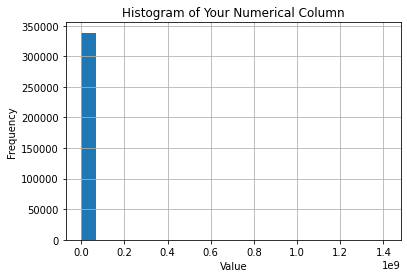

In [65]:
# Plot histogram :

pandas_df = df11.select("price").toPandas()

pandas_df.hist(bins=20)

plt.title("Histogram of Your Numerical Column")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

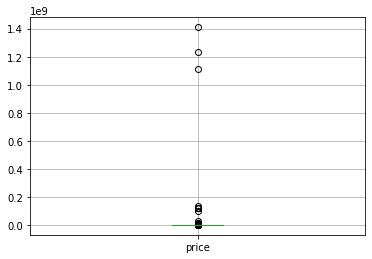

In [66]:
# convert to pandas dataframe:
pandas_df = df11.select("price").toPandas()

# Create a boxplot using Pandas
pandas_df.boxplot(column="price")

plt.show()

In [78]:
# checking count before removing outliers:
df11.count()

338589

In [67]:
# Calculate quartiles

price_percentiles = df11.approxQuantile("price", [0.15, 0.75], 0.01)
price_percentile15 = price_percentiles[0]
price_percentile75 = price_percentiles[1]

# Calculate IQR and upper/lower limits

price_iqr = price_percentile75 - price_percentile15
price_upper_limit = price_percentile75 + 1.5 * price_iqr
price_lower_limit = price_percentile15

# Filter DataFrame based on limits
df12 = df11.filter((col("price") < price_upper_limit) & (col("price") > price_lower_limit))


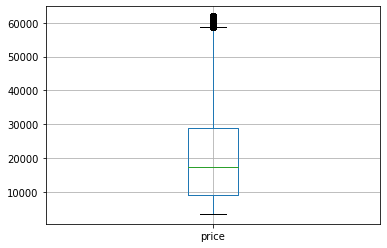

In [68]:
# convert to pandas dataframe:
pandas_df = df12.select("price").toPandas()

# Create a boxplot using Pandas
pandas_df.boxplot(column="price")

plt.show()

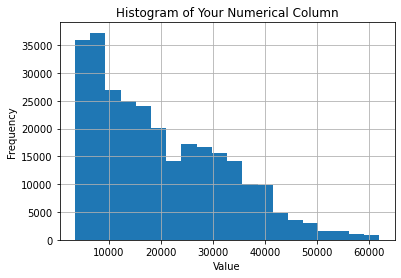

In [69]:
# histogram after removal of outliers:
pandas_df = df12.select("price").toPandas()

pandas_df.hist(bins=20)
plt.title("Histogram of Your Numerical Column")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [71]:
# checking count after outliers:
df12.count()

283296

### odometer :

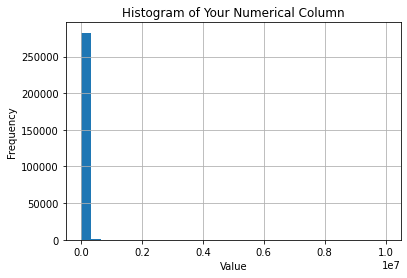

In [72]:
# Plot histogram :
pandas_df = df12.select("odometer").toPandas()

pandas_df.hist(bins=30)
plt.title("Histogram of Your Numerical Column")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

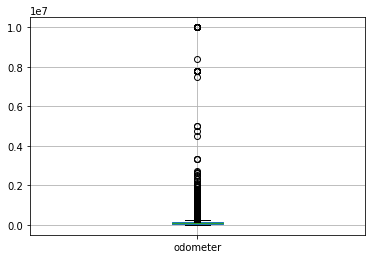

In [73]:
# convert to pandas dataframe:
pandas_df = df12.select('odometer').toPandas()

# Create a boxplot using Pandas
pandas_df.boxplot(column='odometer')

# Display the plot
plt.show()

In [79]:
# checking count before removing outliers:
df12.count()

283296

In [74]:
# Calculate percentiles
odometer_percentiles = df12.approxQuantile("odometer", [0.05, 0.25, 0.75], 0.01)
odometer_percentile05 = odometer_percentiles[0]
odometer_percentile25 = odometer_percentiles[1]
odometer_percentile75 = odometer_percentiles[2]

# Calculate IQR and upper/lower limits
odometer_iqr = odometer_percentile75 - odometer_percentile25
odometer_upper_limit = odometer_percentile75 + 1.5 * odometer_iqr
odometer_lower_limit = odometer_percentile05

# Filter DataFrame based on limits
df13 = df12.filter((col("odometer") < odometer_upper_limit) & (col("odometer") > odometer_lower_limit))


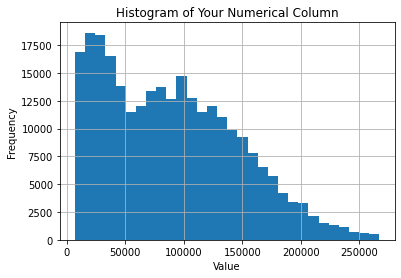

In [75]:
# histogram after removal of outliers:
pandas_df = df13.select("odometer").toPandas()

pandas_df.hist(bins=30)
plt.title("Histogram of Your Numerical Column")
plt.xlabel("Value") 
plt.ylabel("Frequency")
plt.show()

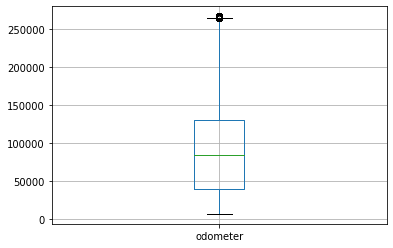

In [77]:
pandas_df = df13.select('odometer').toPandas()

pandas_df.boxplot(column='odometer')

# Display the plot
plt.show()

In [85]:
# checking count after outliers:
df13.count()

267802

## Feature Engineering :

#### year column :

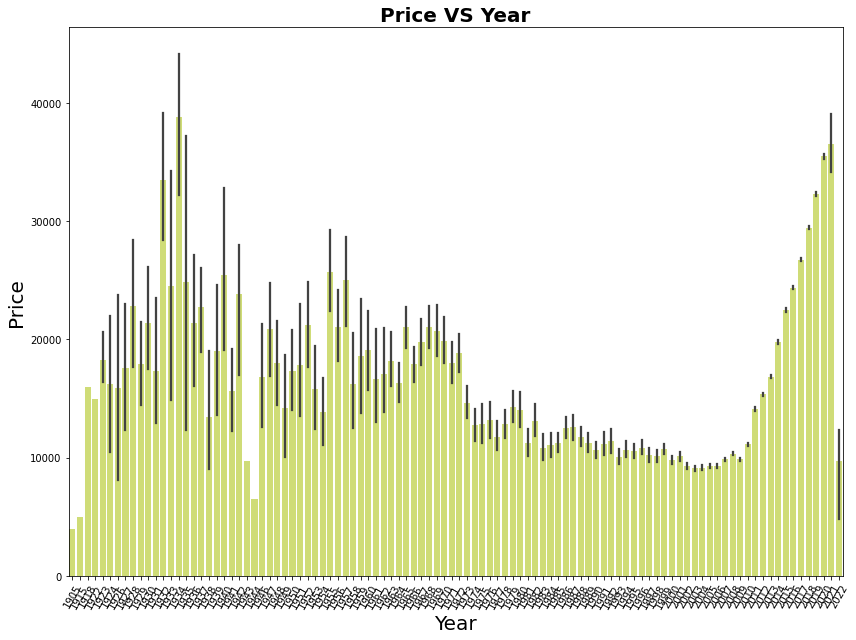

In [80]:
new_df = df13.select("price","year").toPandas()

# Set up plot parameters
plt.rcParams["figure.autolayout"] = True
sns.set_palette('summer_r')
plt.figure(figsize=(12, 9))

# Plot
sns.barplot(y=new_df['price'], x=new_df['year'])
plt.title("Price VS Year", fontsize=20, fontweight='bold')
plt.xlabel('Year', fontsize=20)
plt.xticks(rotation=60)
plt.ylabel('Price', fontsize=20)
plt.tight_layout()
plt.show()

We can see the car data before 1996 is quiet irrelevant with our current times data. So we are extracting all the car data available after 1996

In [81]:
# count before removing the year records:
df13.count()

267802

In [82]:
# Filter DataFrame based on the condition
df14 = df13.where(df13['year'] > 1996)

In [84]:
# count after removing the year rows :
df14.count()

259083

#### count distinct records of each column:

In [83]:
for col_name in df14.columns:

    distinct_count = df14.select(countDistinct(col_name)).collect()[0][0]
    print(col_name, distinct_count)

region 51
price 12243
year 26
manufacturer 21
model 51
condition 7
cylinders 9
fuel 5
odometer 82190
title_status 6
transmission 3
drive 4
type 14
paint_color 13


#### Calculate car age and add it as a new column 'car_age' and drop year column :

In [85]:
df15 = df14.withColumn('car_age', 2022 - col('year'))

df16 = df15.drop('year')

df16.show(  )

+------+-----+-------------+------+---------+-----------+------+--------+------------+------------+-------+-------+-----------+-------+
|region|price| manufacturer| model|condition|  cylinders|  fuel|odometer|title_status|transmission|  drive|   type|paint_color|car_age|
+------+-----+-------------+------+---------+-----------+------+--------+------------+------------+-------+-------+-----------+-------+
|others| 3850|   volkswagen| jetta|  unknown|    unknown|   gas|  178000|       clean|   automatic|unknown|unknown|    unknown|     12|
|others|45950|       others|others|excellent|8 cylinders|diesel|  154289|       clean|   automatic|    4wd|  truck|      black|      8|
|others| 5000|         jeep|others|  unknown|    unknown|diesel|  194000|       clean|   automatic|unknown|    SUV|    unknown|     16|
|others| 3800|          kia|others|  unknown|6 cylinders|   gas|  112412|       clean|   automatic|    fwd|  sedan|       grey|     16|
|others|27590|    chevrolet|others|     good|   

In [86]:
df16.printSchema()

root
 |-- region: string (nullable = false)
 |-- price: integer (nullable = true)
 |-- manufacturer: string (nullable = false)
 |-- model: string (nullable = false)
 |-- condition: string (nullable = false)
 |-- cylinders: string (nullable = false)
 |-- fuel: string (nullable = false)
 |-- odometer: integer (nullable = true)
 |-- title_status: string (nullable = false)
 |-- transmission: string (nullable = false)
 |-- drive: string (nullable = false)
 |-- type: string (nullable = false)
 |-- paint_color: string (nullable = false)
 |-- car_age: integer (nullable = true)



In [87]:
# check final count :
df16.count()

259083

In [88]:
# Calculate the sum of null values for each column
null_counts = df16.select([spark_sum(col(column).isNull().cast('int')).alias(column) for column in df16.columns])

# Show the counts
null_counts.show()


+------+-----+------------+-----+---------+---------+----+--------+------------+------------+-----+----+-----------+-------+
|region|price|manufacturer|model|condition|cylinders|fuel|odometer|title_status|transmission|drive|type|paint_color|car_age|
+------+-----+------------+-----+---------+---------+----+--------+------------+------------+-----+----+-----------+-------+
|     0|    0|           0|    0|        0|        0|   0|       0|           0|           0|    0|   0|          0|      0|
+------+-----+------------+-----+---------+---------+----+--------+------------+------------+-----+----+-----------+-------+



In [104]:
df16.show()

+------+-----+-------------+------+---------+-----------+------+--------+------------+------------+-------+-------+-----------+-------+
|region|price| manufacturer| model|condition|  cylinders|  fuel|odometer|title_status|transmission|  drive|   type|paint_color|car_age|
+------+-----+-------------+------+---------+-----------+------+--------+------------+------------+-------+-------+-----------+-------+
|others| 3850|   volkswagen| jetta|  unknown|    unknown|   gas|  178000|       clean|   automatic|unknown|unknown|    unknown|     12|
|others|45950|       others|others|excellent|8 cylinders|diesel|  154289|       clean|   automatic|    4wd|  truck|      black|      8|
|others| 5000|         jeep|others|  unknown|    unknown|diesel|  194000|       clean|   automatic|unknown|    SUV|    unknown|     16|
|others| 3800|          kia|others|  unknown|6 cylinders|   gas|  112412|       clean|   automatic|    fwd|  sedan|       grey|     16|
|others|27590|    chevrolet|others|     good|   

##### Save DataFrame to a single CSV file for further tableau analysis :
df16.coalesce(1).write.csv("file:///D:/DBDA/new_vehicle_EDA_1.csv", header=True)

### Data Visualization using pandas :

#### ploting pair-plot :  distribution

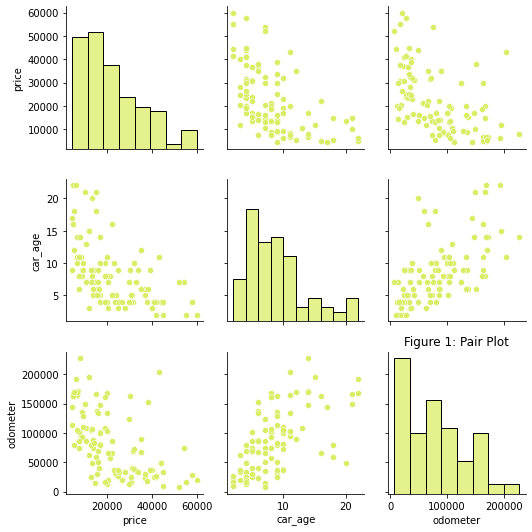

In [91]:
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df16.select("price","car_age",'odometer','fuel','condition').toPandas()

sample_data = pandas_df.sample(100)

# Create pair plot using seaborn
sns.pairplot(sample_data)
plt.title('Figure 1: Pair Plot')
plt.tight_layout()

# Display the plot
plt.show()

#### ploting heatmap : correlation 

<AxesSubplot:>

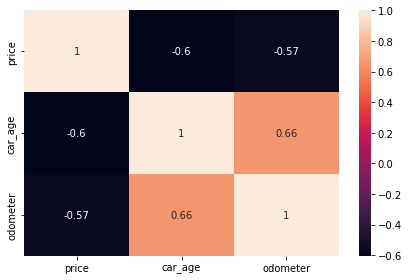

In [92]:
sns.heatmap(pandas_df.corr(), annot=True)

#### subplots :

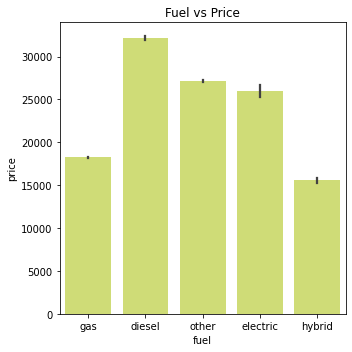

In [93]:
fig,axs=plt.subplots()
fig.set_size_inches(5,5)

p1=sns.barplot(x='fuel',y='price',data=pandas_df,ax=axs)
axs.set_title('Fuel vs Price')

plt.savefig('Insight-Figure-1',dpi=None)
plt.show()

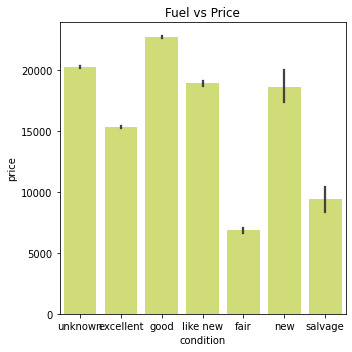

In [98]:
fig,axs=plt.subplots()
fig.set_size_inches(5,5)

p1=sns.barplot(x='condition',y='price',data=pandas_df,ax=axs)
axs.set_title('Fuel vs Price')

plt.savefig('Insight-Figure-1',dpi=None)
plt.show()

#### barplot :

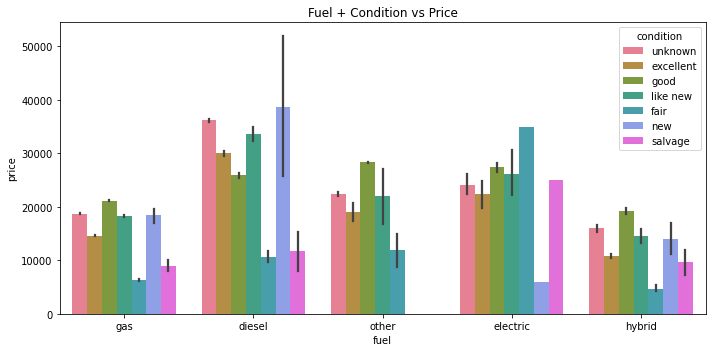

In [94]:
plt.figure(figsize=(10,5))
sns.barplot(x='fuel',y='price',hue='condition',data=pandas_df)
plt.title('Fuel + Condition vs Price')
plt.savefig('Insight-Figure-2',dpi=None)
plt.show()

### Model Training :

In [95]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler,StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

train, test = df16.randomSplit([0.75, 0.25])

numerical=["odometer","car_age"]

numerical_vector_assembler = VectorAssembler(inputCols=numerical,
                                             outputCol='numerical_feature_vector')

train = numerical_vector_assembler.transform(train)
test = numerical_vector_assembler.transform(test)


scaler = StandardScaler(inputCol='numerical_feature_vector',
                        outputCol='scaled_numerical_feature_vector',
                        withStd=True, withMean=True)

scaler = scaler.fit(train)

train = scaler.transform(train)
test = scaler.transform(test)


indexer = StringIndexer(inputCols=['manufacturer','model','condition','cylinders','fuel','title_status','transmission','drive','type','paint_color','region'],
                        outputCols=['manufacturer_index','m_i','co_i','cy_i','f_i','ts_i','tr_i','d_i','ty_i','p_i','r_i'],handleInvalid="keep")

indexer = indexer.fit(train)
train = indexer.transform(train)
test = indexer.transform(test)



one_hot_encoder = OneHotEncoder(inputCols=['manufacturer_index','m_i','co_i','cy_i','f_i','ts_i','tr_i','d_i','ty_i','p_i','r_i'],
                                outputCols=['manufacturer_index_h','m_i_h','co_i_h','cy_i_h','f_i_h','ts_i_h','tr_i_h','d_i_h','ty_i_h','p_i_h','r_i_h'])

one_hot_encoder = one_hot_encoder.fit(train)

train = one_hot_encoder.transform(train)
test = one_hot_encoder.transform(test)

assembler = VectorAssembler(inputCols=['scaled_numerical_feature_vector',
                                       'manufacturer_index_h','m_i_h','co_i_h','cy_i_h','f_i_h','ts_i_h','tr_i_h','d_i_h','ty_i_h','p_i_h','r_i_h'],
                            outputCol='final_feature_vector')

train = assembler.transform(train)
test = assembler.transform(test)



lr = LinearRegression(featuresCol='final_feature_vector',
                      labelCol='price')


lr=lr.fit(train)
pred_train_df = lr.transform(train).withColumnRenamed('prediction',
                                                      'predicted_vehicle_value')

pred_train_df.show(5)

pred_test_df = lr.transform(test).withColumnRenamed('prediction','predicted_vehicle_value')

result=lr.evaluate(test)
print(result.r2)
unlabeled_data=test.select("final_feature_vector")
predictions=lr.transform(unlabeled_data)
predictions.show(20)

+-----------+-----+-------------+------+---------+-----------+----+--------+------------+------------+-------+-------+-----------+-------+------------------------+-------------------------------+------------------+----+----+----+---+----+----+---+----+---+----+--------------------+---------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+--------------+---------------+--------------------+-----------------------+
|     region|price| manufacturer| model|condition|  cylinders|fuel|odometer|title_status|transmission|  drive|   type|paint_color|car_age|numerical_feature_vector|scaled_numerical_feature_vector|manufacturer_index| m_i|co_i|cy_i|f_i|ts_i|tr_i|d_i|ty_i|p_i| r_i|manufacturer_index_h|          m_i_h|       co_i_h|       cy_i_h|        f_i_h|       ts_i_h|       tr_i_h|        d_i_h|        ty_i_h|         p_i_h|          r_i_h|final_feature_vector|predicted_vehicle_value|
+-----------+-----+-------------+------+---------+--